# Transfer Learning

## 1. Get started

In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
print(f'Pytorch version: {torch.__version__}')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
try:
    print(f'CUDA version: {torch.version.cuda}')
except: 
    pass

Pytorch version: 1.1.0
cuda
CUDA version: 9.0.176


## 2. Preprocess dataset

In [3]:
dataset_root_dir = '../dataset/'

In [4]:
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)

    def __getitem__(self, idx):
        '''
        Get image and its label at index `idx`.
        '''
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1

### Visualize dataset

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
train_set = BirdsDataset(dataset_root_dir)
# get a sample of training set
x = train_set[10]

<IPython.core.display.Javascript object>


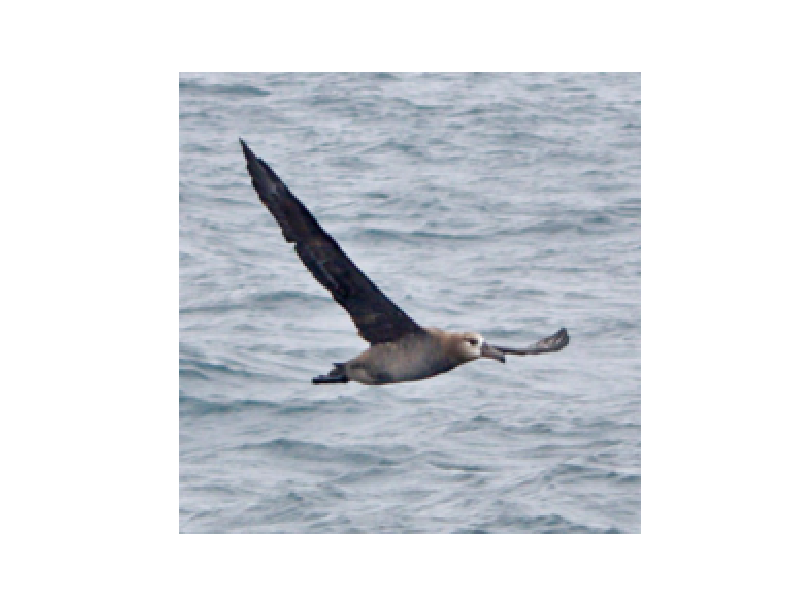

In [7]:
plt.figure()
# [0] is image, [1] is label
myimshow(x[0])

### What is Data Loader

`train_loader` splits `train_set` into shuffled mini-batches of size `16`.

In [8]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

#### What is the advantage of using `pin_memory`?
The data loader will copy tensors into CUDA pinned memory before returning them. This lets the `DataLoader` allocate the samples in page-locked memory, which speeds-up the transfer.

In [9]:
# How many mini-batches are there?
len(train_loader)

47

#### Since we use `shuffle=True`, every time we call the DataLoader it will give us different samples.

Display the first image and label pair of the first four mini-batches.

<IPython.core.display.Javascript object>


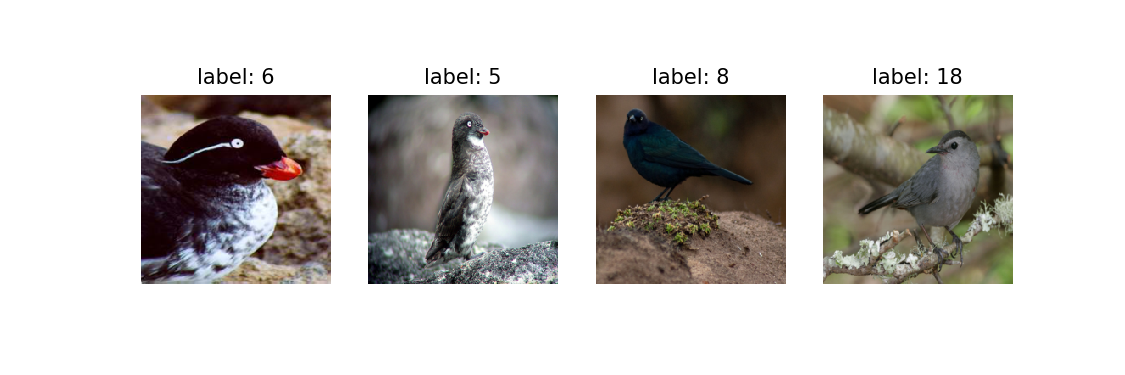

<IPython.core.display.Javascript object>


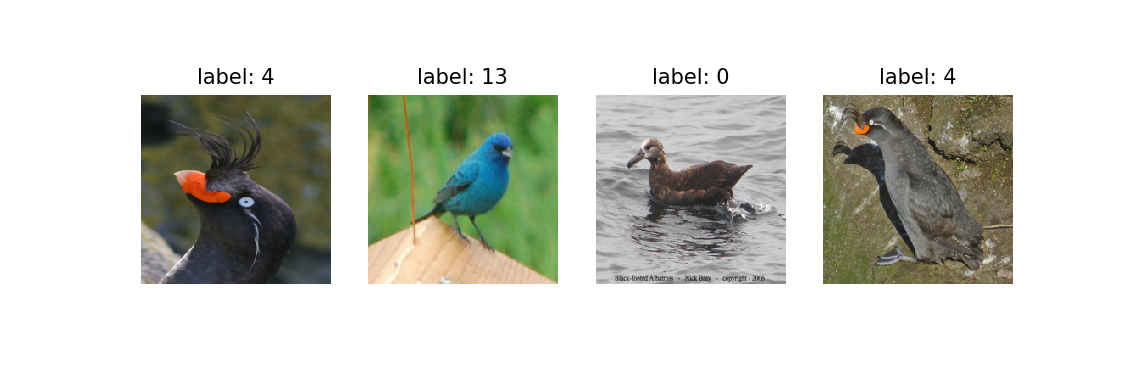

In [10]:
for _ in range(2):
    fig, axes = plt.subplots(ncols=4, figsize=(9, 3))
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx == 4:  # first four mini-batches
            break
        myimshow(batch[0][0], ax=axes[batch_idx])
        axes[batch_idx].set_title(f'label: {batch[1][0]}')

**NOTE:**
1. To get access to data in `torch.utils.data.DataLoader`, we have to use loop.  

2. `for batch_idx, batch in enumerate(train_loader):` dataloader returns a minibatch (with batch-size 16) each time.  

3. `batch` is a tuple `(images, labels)`. For example, to access the first image, we use `batch[0][0]`; similarily, use `batch[1][0]` to obtain the correspoding label of the first image.

4. Use `for _ in range(2):` to re-evaluate dataloader. I observer that dataloader re-generate data from the training set, and thus the first four images at first time are different from those at second time.

#### We do not need to use `shuffle` for the validation set.

We shuffle the dataset for training to converge fast because similar data points might lie next to each other. As for the validation set, it is used for performance evaluation of the model. No matter shuffle the validation set or not, it cannot change the parameters and the performance of the model.

In [11]:
val_set = BirdsDataset(dataset_root_dir, mode='val')

In [12]:
val_loader = td.DataLoader(val_set, batch_size=16, pin_memory=True)

<IPython.core.display.Javascript object>


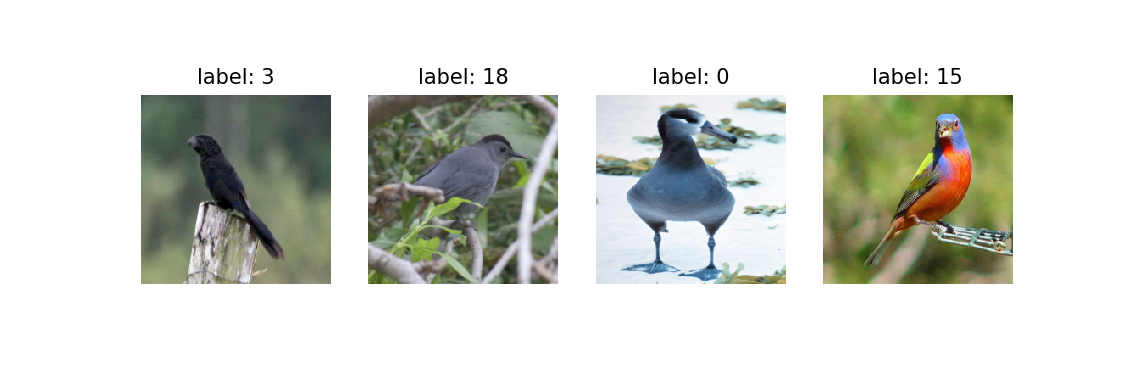

<IPython.core.display.Javascript object>


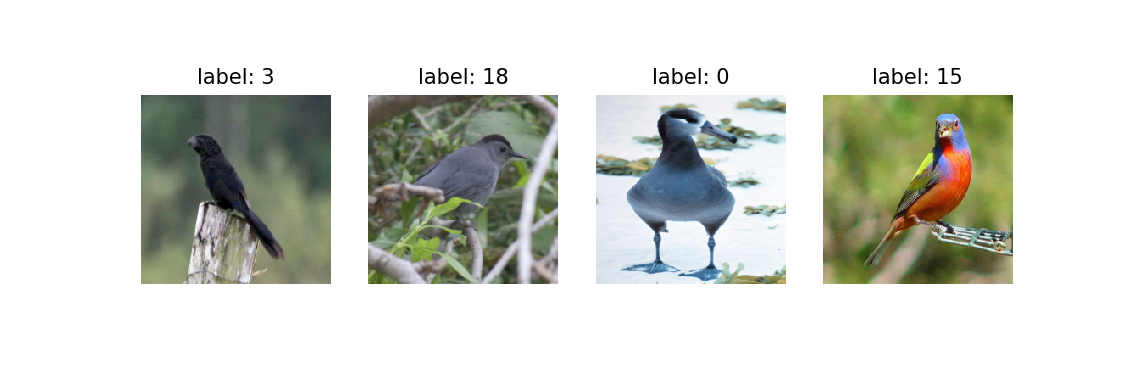

In [13]:
for _ in range(2):
    fig, axes = plt.subplots(ncols=4, figsize=(9, 3))
    for batch_idx, batch in enumerate(val_loader):
        if batch_idx == 4:  # first four mini-batches
            break
        myimshow(batch[0][0], ax=axes[batch_idx])
        axes[batch_idx].set_title(f'label: {batch[1][0]}')

## 3. Abstract Neural Network Model

In [14]:
import nntools as nt

In [15]:
help(nt.NeuralNetwork)

Help on class NeuralNetwork in module nntools:

class NeuralNetwork(torch.nn.modules.module.Module, abc.ABC)
 |  An abstract class representing a neural network.
 |  
 |  All other neural network should subclass it. All subclasses should override
 |  ``forward``, that makes a prediction for its input argument, and
 |  ``criterion``, that evaluates the fit between a prediction and a desired
 |  output. This class inherits from ``nn.Module`` and overloads the method
 |  ``named_parameters`` such that only parameters that require gradient
 |  computation are returned. Unlike ``nn.Module``, it also provides a property
 |  ``device`` that returns the current device in which the network is stored
 |  (assuming all network parameters are stored on the same device).
 |  
 |  Method resolution order:
 |      NeuralNetwork
 |      torch.nn.modules.module.Module
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(s

#### All of methods in the abstract class does not be implemented, it cannot be instantiated.

In [16]:
try:
    net = nt.NeuralNetwork()
except:
    print("TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward")

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward


#### Implement an abstract class which considers only neural networks that will produce one-hot codes and that are then classifiers.

In [17]:
class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## 4. VGG-16 Transfer Learning

`VGG` is a very popular network for transfer learning and is widely used as a feature extractor for multiple computer vision tasks. Here, we will use the 16-layer version of the `VGG` with batch norm from torchvision package `vgg16_bn`. We will replace the final fully connected (FC) layer with a one specific to our task. We will then train only this task-specific last FC layer and will keep all other layers as frozen (i.e., they will not be trained). The main advantage of transfer learning is that we are enabling transfer of knowledge gained by model on one task to be adapted to learn another task. It also reduces drastically the number of parameters to learn, hence, avoiding overfitting and making the training to converge in just a few epochs.

### Load pretrained model

In [18]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [19]:
# network structure
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [20]:
# learnable parameters of network
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

### Modify the classifier of pretrained model

A new subclass `VGG16Transfer` that inherits from `NNClassifier`

In [21]:
class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        f = self.features(x).view(x.shape[0], -1)       
        y = self.classifier(f)
        return y

**Note:** `fine_tuning=True` can be used if we were willing to retrain (fine tune) all other layers, but this will take much more time and memory. This would also require more data (or using a very small learning rate and carefully monitoring the loss) as the number of parameters would be much higher, and the procedure subject to overfitting.

In [22]:
num_classes = train_set.number_of_classes()

In [23]:
vgg16transfer = VGG16Transfer(num_classes)

In [24]:
# network structure
vgg16transfer

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [25]:
# learnable parameters of network
for name, param in vgg16transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.6.weight torch.Size([20, 4096]) True
classifier.6.bias torch.Size([20]) True


## 5. Training experiment and checkpoints

#### A new subclass `ClassificationStatsManager` that inherits from `StatsManager`

In [26]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

* `model.eval()` will notify all layers that they are in eval mode, and `batchnorm` or `dropout` layers will work in eval mode instead of training mode. Since we have `batchnorm` layers in our `VGG16Transfer()`, it matters that we switch to eval mode.

* About `batchnorm`: During training, this layer keeps a running estimate of its computed mean and variance. The running sum is kept with a default momentum of 0.1. On the other hand, during evaluation, this running mean/variance is used for normalization.

* `torch.no_grad()` impacts the autograd engine and deactivate it. It will reduce memory usage, speed up computations and stop backprop, which we don’t need in an eval script.

### model settings

In [27]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

#### Visualize the `config.txt`
We can see that it is about the structure and hyperparameters of the model, training set and validation set, and other functions and parameters that we use, such as `StatsManager`, `BatchSize` and `PerformValidationDuringTraining`.

In [28]:
!cat birdclass1/config.txt

Net(VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

#### What does the file `checkpoint.pth.tar` correspond to?  

According to `nntools.py` and `torch.save()`, this file save an object, which is a dictionary of `Net`, `Optimizer` and `History`, to a disk file, i.e. the file name. 


#### If we use a different model setting, it will raise an error.

In [29]:
lr = 1e-4
#net = VGG16Transfer(num_classes)
#net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
#stats_manager = ClassificationStatsManager()
try:
    exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)
except ValueError:
    print("ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.")

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.


According to `__init__()` in `Experiement`, it will check the setting of the model. Since learning is one of the setting of model, the experiement with learning rate `1e-4` fail to be executed.

Note: It is under the condition that you use the same `output_dir`. The program will load the checkpoint, so it needs the same setting of the saved model, or it will raise `ValueError`.

### Run the model

In [30]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    # training loss
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    # evaluation loss
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(('training loss', 'evaluation loss'))
    
    # training accuracy
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="training accuracy")
    # evaluation accuracy
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                 label="evaluation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(('training accuracy', 'evaluation accuracy'), loc='lower right')
    
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


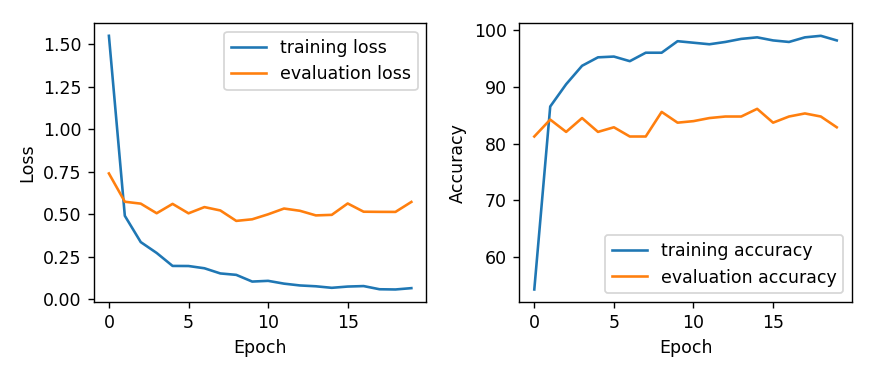

Start/Continue training from epoch 20
Finish training for 20 epochs


In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## 6. ResNet18 Transfer Learning

### Load pretrained model

In [32]:
resnet = tv.models.resnet18(pretrained=True)

In [33]:
# network structure
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Modify the classifier of pretrained model
A subclass `Resnet18Transfer` that inherits from `NNClassifer`

In [34]:
class Resnet18Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.classifier = resnet
        num_ftrs = resnet.fc.in_features
        self.classifier.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):     
        y = self.classifier(x)
        return y

In [35]:
resnet18transfer = Resnet18Transfer(num_classes)

In [36]:
# network structure
resnet18transfer

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

In [37]:
# learnable parameters of network
for name, param in resnet18transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.fc.weight torch.Size([20, 512]) True
classifier.fc.bias torch.Size([20]) True


### Run the model

In [38]:
lr2 = 1e-3
net2 = Resnet18Transfer(num_classes)
net2 = net2.to(device)
adam2 = torch.optim.Adam(net2.parameters(), lr=lr2)
stats_manager2 = ClassificationStatsManager()
exp2 = nt.Experiment(net2, train_set, val_set, adam2, stats_manager2,
               output_dir="birdclass2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


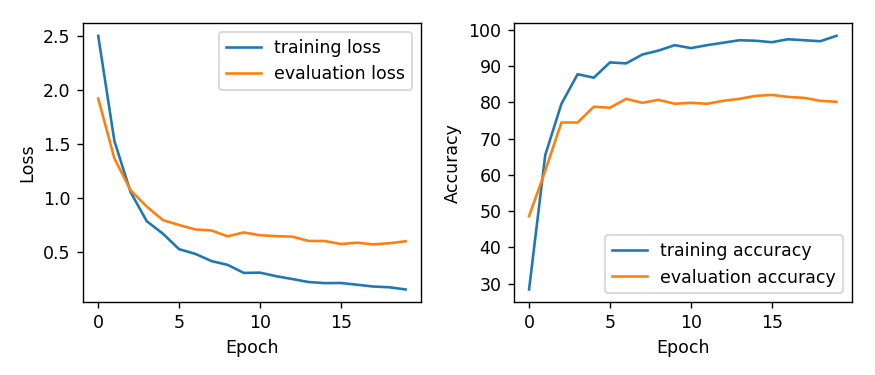

Start/Continue training from epoch 0
Epoch 1 | Time: 11.04s | Training Loss: 2.505389 | Evaluation Loss: 1.922759
Epoch 2 | Time: 10.13s | Training Loss: 1.527481 | Evaluation Loss: 1.366010
Epoch 3 | Time: 10.57s | Training Loss: 1.052675 | Evaluation Loss: 1.069934
Epoch 4 | Time: 10.20s | Training Loss: 0.782093 | Evaluation Loss: 0.918239
Epoch 5 | Time: 10.88s | Training Loss: 0.665983 | Evaluation Loss: 0.792521
Epoch 6 | Time: 11.04s | Training Loss: 0.522208 | Evaluation Loss: 0.746735
Epoch 7 | Time: 10.88s | Training Loss: 0.478739 | Evaluation Loss: 0.705658
Epoch 8 | Time: 10.57s | Training Loss: 0.411760 | Evaluation Loss: 0.696044
Epoch 9 | Time: 10.53s | Training Loss: 0.376340 | Evaluation Loss: 0.641736
Epoch 10 | Time: 10.38s | Training Loss: 0.301379 | Evaluation Loss: 0.677929
Epoch 11 | Time: 10.85s | Training Loss: 0.303988 | Evaluation Loss: 0.651578
Epoch 12 | Time: 10.14s | Training Loss: 0.271186 | Evaluation Loss: 0.643318
Epoch 13 | Time: 10.22s | Training L

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

### Performance comparison

In [40]:
# evaluation of vgg
exp1.evaluate()

{'loss': 0.573483667295912, 'accuracy': tensor(82.8804, device='cuda:0')}

In [41]:
# evaluation of resnet
exp2.evaluate()

{'loss': 0.5960313282583071, 'accuracy': tensor(80.1630, device='cuda:0')}

The loss of `Resnet18Transfer` is a bit higher than that of `VGG16Transfer` and the accuracy of `VGG16Transfer` is higher than that of `Resnet18Transfer`. The reason of this result might be that since we have limited number of dataset and thus if we use a deeper network might not have a good performance.

PS: `Resnet18` extracts 512 features, `VGG16` extracts 4096 features. In this very small dataset context, I would have expect that using 512 features will be more suitable than using 4096 because of curse of dimensionality. But to be fair, we should take into consideration the depth, effective receptive fields, etc that were used to obtain these features.